In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# 1. Download price data
ticker = 'SPY'
data = yf.download(ticker, start='2015-01-01', end='2025-01-01', auto_adjust=False)
print(data.columns)
# data = data[['Adj Close']]
# data.rename(columns={'Adj Close': 'Price'}, inplace=True)

[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'SPY'),
            (    'Close', 'SPY'),
            (     'High', 'SPY'),
            (      'Low', 'SPY'),
            (     'Open', 'SPY'),
            (   'Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [25]:
# 2. If the DataFrame has a MultiIndex, flatten it
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]  # Extract first level (like 'Close')

print(data.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [28]:
# 3. Use Adjusted Close for accurate returns
if 'Adj Close' in data.columns:
    data['Price'] = data['Adj Close']
else:
    data['Price'] = data['Close']  # fallback

# 4. Compute moving averages
data['SMA20'] = data['Price'].rolling(window=20).mean()
data['SMA100'] = data['Price'].rolling(window=100).mean()

In [30]:
# 6. Calculate returns
data['Market Return'] = data['Price'].pct_change()
# 1. Calculate rolling 14-day volatility (standard deviation of returns)
data['Volatility'] = data['Market Return'].rolling(window=14).std()

# 2. Define a simple volatility threshold (e.g., 2% daily std dev)
vol_threshold = 0.02

# 3. Filter the signal: only set Signal = 1 when volatility is below threshold
data['Signal'] = 0
data.loc[(data['SMA20'] > data['SMA100']) & (data['Volatility'] < vol_threshold), 'Signal'] = 1

# 4. Position logic stays the same
data['Position'] = data['Signal'].shift(1)

In [31]:



data['Strategy Return'] = data['Market Return'] * data['Position']

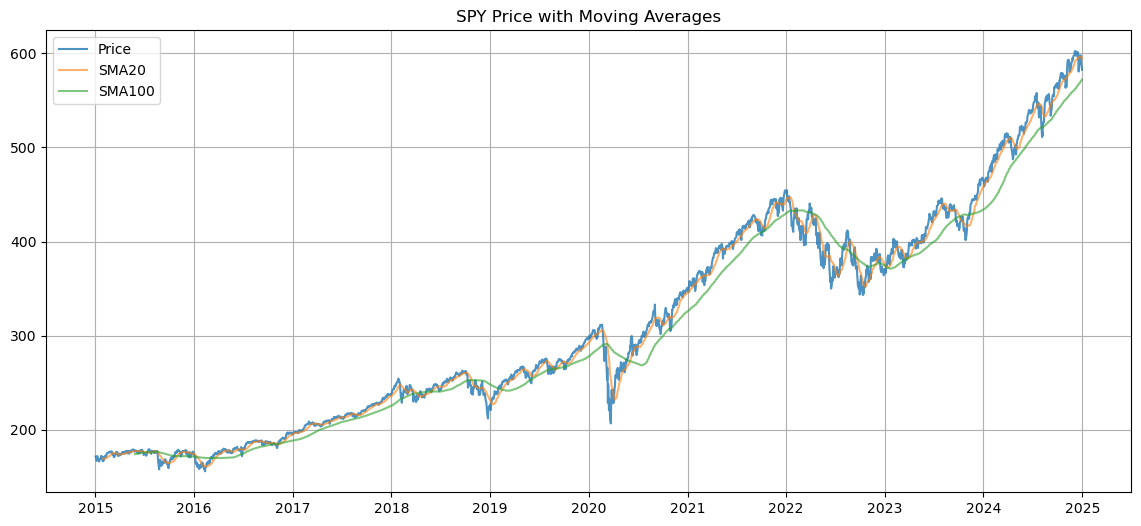

In [32]:
# 7. Plot price and moving averages
plt.figure(figsize=(14, 6))
plt.plot(data['Price'], label='Price', alpha=0.8)
plt.plot(data['SMA20'], label='SMA20', alpha=0.6)
plt.plot(data['SMA100'], label='SMA100', alpha=0.6)
plt.title('SPY Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()

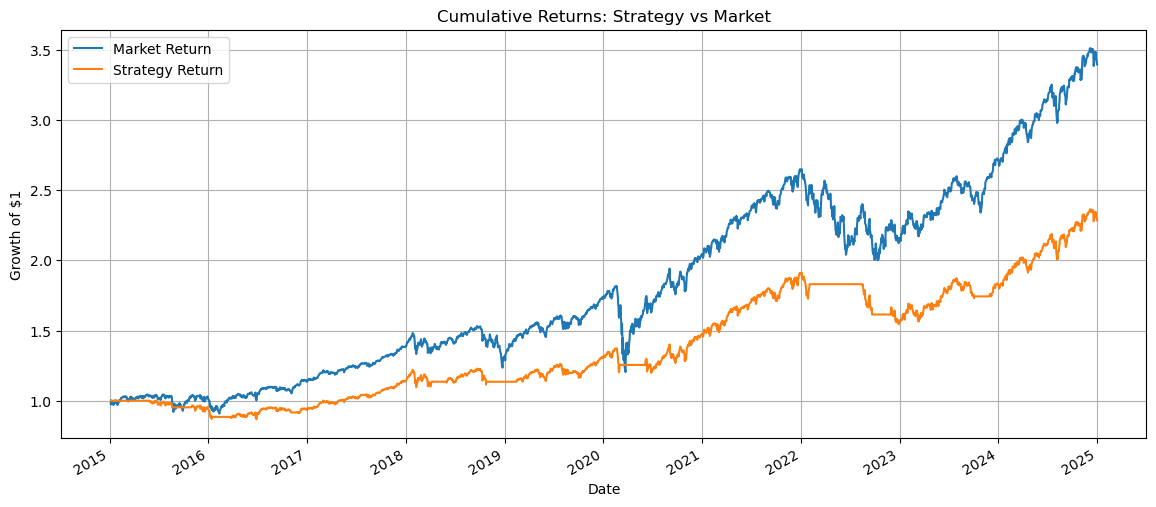

In [33]:
# 8. Plot cumulative returns
(1 + data[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(14, 6))
plt.title('Cumulative Returns: Strategy vs Market')
plt.ylabel('Growth of $1')
plt.grid(True)
plt.show()

In [34]:
data.to_csv("moving_avg_strategy_output.csv")

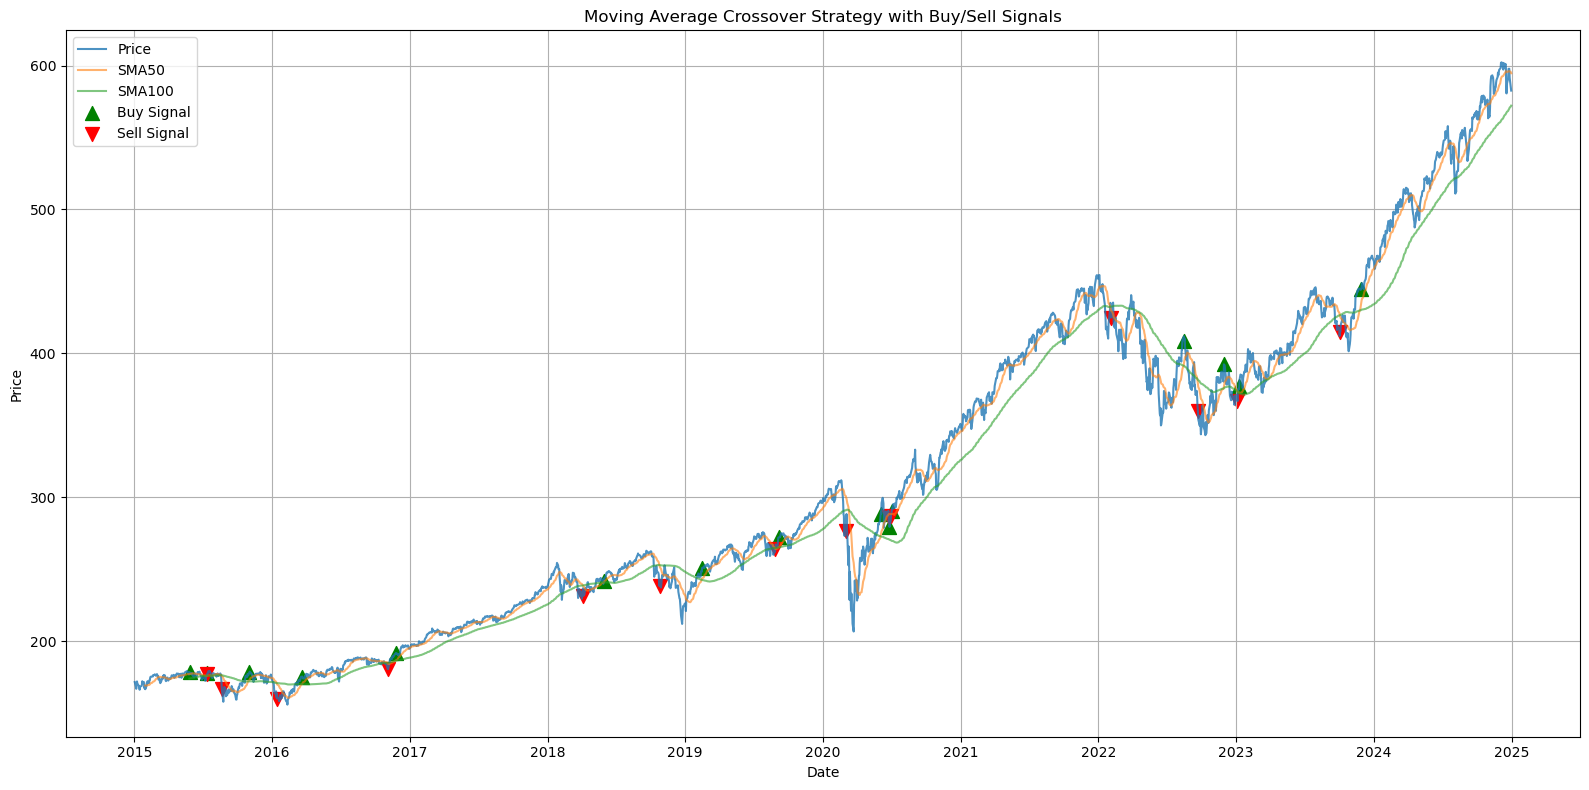

In [35]:
# Identify buy and sell signals
buy_signals = data[(data['Position'] == 1) & (data['Position'].shift(1) == 0)]
sell_signals = data[(data['Position'] == 0) & (data['Position'].shift(1) == 1)]

# Plot price, moving averages, and signals
plt.figure(figsize=(16, 8))
plt.plot(data['Price'], label='Price', alpha=0.8)
plt.plot(data['SMA20'], label='SMA50', alpha=0.6)
plt.plot(data['SMA100'], label='SMA100', alpha=0.6)
plt.scatter(buy_signals.index, buy_signals['Price'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['Price'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('Moving Average Crossover Strategy with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Set up the basic structure for a multi-asset, multi-parameter backtest

import yfinance as yf
import pandas as pd
import numpy as np

# Define assets to test
assets = ["SPY", "QQQ", "IWM", "XLF", "XLK", "AAPL", "MSFT"]

# Define parameter grid (SMA short and long combinations)
sma_short_windows = [10, 20, 50]
sma_long_windows = [50, 100, 200]
vol_threshold = 0.02  # fixed for this first test

# Store results
results = []

# Loop through each asset and parameter combo
for ticker in assets:
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", auto_adjust=False)
    data = data[['Adj Close']].rename(columns={'Adj Close': 'Price'})
    data['Market Return'] = data['Price'].pct_change()

    for short_win in sma_short_windows:
        for long_win in sma_long_windows:
            if short_win >= long_win:
                continue  # skip invalid combinations

            df = data.copy()
            df[f"SMA{short_win}"] = df['Price'].rolling(window=short_win).mean()
            df[f"SMA{long_win}"] = df['Price'].rolling(window=long_win).mean()
            df['Volatility'] = df['Market Return'].rolling(window=14).std()

            # Signal logic with volatility filter
            df['Signal'] = 0
            df.loc[
                (df[f"SMA{short_win}"] > df[f"SMA{long_win}"]) &
                (df['Volatility'] < vol_threshold),
                'Signal'
            ] = 1
            df['Position'] = df['Signal'].shift(1)

            # Strategy returns
            df['Strategy Return'] = df['Market Return'] * df['Position']
            df['Cumulative Strategy'] = (1 + df['Strategy Return'].fillna(0)).cumprod()
            df['Cumulative Market'] = (1 + df['Market Return'].fillna(0)).cumprod()

            # Metrics
            strategy_return = df['Cumulative Strategy'].iloc[-1]
            market_return = df['Cumulative Market'].iloc[-1]
            strat_ret = df['Strategy Return'].fillna(0)
            daily_return = strat_ret.mean()
            daily_vol = strat_ret.std()
            sharpe = (daily_return / daily_vol) * (252**0.5) if daily_vol > 0 else 0
            max_drawdown = ((df['Cumulative Strategy'] / df['Cumulative Strategy'].cummax()) - 1).min()
            trade_count = df['Position'].diff().abs().sum()
            days_in_market = df['Position'].sum()

            results.append({
                "Ticker": ticker,
                "SMA Short": short_win,
                "SMA Long": long_win,
                "Cumulative Return": strategy_return,
                "Market Return": market_return,
                "Sharpe Ratio": sharpe,
                "Max Drawdown": max_drawdown,
                "Total Trades": trade_count,
                "Days in Market": days_in_market
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
results_df.to_csv("multi_asset_strategy_results.csv", index=False)